In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision.transforms as T
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from tqdm import tqdm
import math
import random
from sklearn.model_selection import train_test_split
from typing import List, Callable, Optional
from nltk.translate.bleu_score import sentence_bleu

import transformers
## Tokenizer
tokenizer = transformers.BertTokenizer.from_pretrained("bert-base-uncased",do_lower_case=True)

## For Reproducibility (Determininstic)
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
seed_everything(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [2]:
filepath =  "/kaggle/input/flickr30k"

# Add filepath to image
df = pd.read_csv(filepath + "/" + "captions.txt")
df = df.drop(columns=['comment_number'])
df.rename(columns={'image_name': 'image', 'comment': 'caption'}, inplace=True)  
df["image"] = filepath + "/flickr30k_images/" + df["image"]
df.head()

image  \
0  /kaggle/input/flickr30k/flickr30k_images/10000...   
1  /kaggle/input/flickr30k/flickr30k_images/10000...   
2  /kaggle/input/flickr30k/flickr30k_images/10000...   
3  /kaggle/input/flickr30k/flickr30k_images/10000...   
4  /kaggle/input/flickr30k/flickr30k_images/10000...   

                                             caption  
0  Two young guys with shaggy hair look at their ...  
1  Two young  White males are outside near many b...  
2   Two men in green shirts are standing in a yard .  
3       A man in a blue shirt standing in a garden .  
4            Two friends enjoy time spent together .

[CLS]: 101
two: 2048
young: 2402
white: 2317
males: 3767
are: 2024
outside: 2648
near: 2379
many: 2116
bushes: 14568
.: 1012
[SEP]: 102
[PAD]: 0


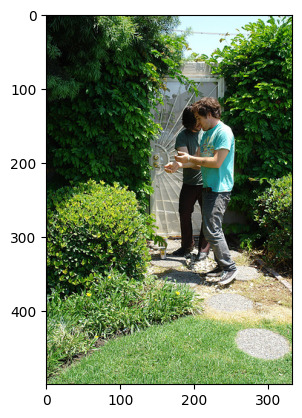

In [3]:
# # Checking filepath is correct for images
img = Image.open(df["image"][0])
plt.imshow(img)

encoded_inputs = tokenizer(df['caption'][1],
                        return_token_type_ids = False, 
                        return_attention_mask = False, 
                        max_length = 100, 
                        padding = "max_length",
                        return_tensors = "pt")

token_ids = encoded_inputs['input_ids'].flatten().tolist()
tokens = tokenizer.convert_ids_to_tokens(token_ids)

token_dict = dict(zip(tokens, token_ids))

for token in tokens:
    print(f"{token}: {token_dict[token]}")
    if(token=='[PAD]'): break

In [4]:
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

class FlickrDataset(Dataset):
    def __init__(self, df, transforms: Optional[Callable] = None) -> None:
        self.df = df
        self.transforms = T.Compose([
            T.ToTensor(),
            T.Normalize(mean, std),
            T.Resize((256, 256)),
        ])
        
    def __len__(self) -> int:
        return len(self.df)

    def __getitem__(self, idx: int):
        image_id = self.df['image'][idx]
        image = Image.open(image_id).convert('RGB')
        
        if self.transforms is not None:
            image = self.transforms(image)
        
        captions = self.df['caption'][idx]
        
        encoded_inputs = tokenizer(
            captions,
            return_token_type_ids=False,
            return_attention_mask=False,
            max_length=100,
            padding="max_length",
            return_tensors="pt"
        )
        
        sample = {
            "image": image.to(device),
            "captions": encoded_inputs["input_ids"].to(device)
        }
        
        return sample

In [5]:
## Train and Test Split 
train, test = train_test_split(df, test_size=0.02, random_state=42)

## Reset Indexes 
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

## Train and Validation Split 
train, val = train_test_split(train, test_size=0.02, random_state=42)

## Reset Indexes 
train = train.reset_index(drop=True)
val = val.reset_index(drop=True)

## Let's see how many entries we have
print(train.shape)
print(val.shape)
print(test.shape)

(152621, 2)
(3115, 2)
(3179, 2)


In [6]:
batch_size = 32

train_dataset = FlickrDataset(train, transforms = True)
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, drop_last=True)

val_dataset = FlickrDataset(val, transforms = True)
val_dataloader = DataLoader(val_dataset, batch_size = batch_size, drop_last=True)

test_dataset = FlickrDataset(test, transforms = True)
test_dataloader = DataLoader(test_dataset, batch_size = batch_size, drop_last=True)

In [7]:
class EncoderCNN(nn.Module):
    def __init__(self, embed_size):
        super(EncoderCNN, self).__init__()
        resnet = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
        for param in resnet.parameters():
            param.requires_grad_(False)
            
        modules = list(resnet.children())[:-1]
        self.resnet = nn.Sequential(*modules)
        self.embed = nn.Sequential(
            nn.Linear(resnet.fc.in_features, embed_size),
            nn.ReLU()
        )
        self.normalize = T.Normalize(mean=[0.485, 0.456, 0.406],
                                              std=[0.229, 0.224, 0.225])

    def forward(self, images):
        images = self.normalize(images)
        features = self.resnet(images)
        features = features.view(features.size(0), -1)
        features = self.embed(features)
        
        return features

In [8]:
class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers=2, dropout=0.5):
        super(DecoderRNN, self).__init__()
        self.embed_size = embed_size
        self.hidden_size = hidden_size
        self.vocab_size = vocab_size
        self.num_layers = num_layers

        self.embed = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size, vocab_size)
        
        # Initialize weights
        self.init_weights()

    def init_weights(self):
        self.embed.weight.data.uniform_(-0.1, 0.1)
        self.fc.bias.data.fill_(0)
        self.fc.weight.data.uniform_(-0.1, 0.1)

    def forward(self, features, captions):
        captions = captions[:, :-1]  # Remove <end> token
        embeddings = self.embed(captions)
        embeddings = torch.cat((features.unsqueeze(1), embeddings), dim=1)
        
        lstm_out, _ = self.lstm(embeddings)
        lstm_out = self.dropout(lstm_out)
        outputs = self.fc(lstm_out)
        
        return outputs

    def sample(self, inputs, states=None, max_len=30):
        res = []
        for i in range(max_len):
            lstm_out, states = self.lstm(inputs, states)
            lstm_out = self.dropout(lstm_out)
            outputs = self.fc(lstm_out.squeeze(1))
            _, predicted_idx = outputs.max(1)
            
            res.append(predicted_idx.item())
            
            if predicted_idx.item() == tokenizer.sep_token_id:  # <SEP> token
                break
                
            inputs = self.embed(predicted_idx).unsqueeze(1)
        
        return res

In [9]:
batch_size = 32  # batch size
vocab_size = tokenizer.vocab_size
embed_size = 256  # dimensionality of image and word embeddings
hidden_size = 512  # number of features in hidden state of the RNN decoder
num_epochs = 5  # number of training epochs
save_every = 1  # determines frequency of saving model weights
print_every = 20  # determines window for printing average loss
steps_per_epoch = len(train_dataloader.dataset) // batch_size

encoder = EncoderCNN(embed_size).to(device)
decoder = DecoderRNN(embed_size, hidden_size, vocab_size).to(device)

criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(list(decoder.parameters()) + list(encoder.embed.parameters()), lr=0.001)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 157MB/s]


In [10]:
# Normalization parameters for pre-trained PyTorch models
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

def denormalize(tensor, mean, std):
    """Denormalize a tensor with mean and std"""
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor

def show_example(encoder, decoder, val_dataloader):
     # Set models to evaluation mode
    encoder.eval()
    decoder.eval()

    example = next(iter(val_dataloader))
    img = example['image'][20]
    cap = example['captions'][20]
    
    with torch.no_grad():
        features = encoder(img.unsqueeze(0))
        embed = decoder(features, cap)

    image = denormalize(img, mean, std).cpu().permute(1, 2, 0).clone()
    caption = tokenizer.decode(embed.squeeze(0).argmax(dim=-1), skip_special_tokens=True)
    orig_caption = tokenizer.decode(cap.squeeze(0), skip_special_tokens=True)

    plt.imshow(image)
    print(f"\nGenerated Caption: ", caption)
    print(f"\nOriginal Caption: ", orig_caption)
    plt.show()

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Generated Caption:  vimes diagnostic diagnostic diagnosticlettlettlettlett warlord warlord warlord warlord warlordlett warlord fulfilling fulfilling ो ो ो ो ो ो ो ो ो ो ो ो ो ो ो ो ो ो ो ो ो ो ो ो ो ो ो ो ो ो ो ो ो ो ो ो ो ो ो ो ो ो ो ो ो ो ो ो ो ो ो ो ो ो ो ो ो ो ो ो ो ो ो ो ो ो ो ो ो ो ो ो ो ो ो ो ो ो ो ो ो ो ो

Original Caption:  a man in a wetsuit trying to balance on a surfboard.


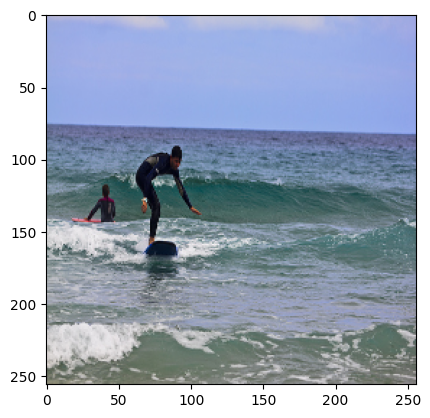

In [11]:
show_example(encoder, decoder, val_dataloader)

In [12]:
model_path = "/kaggle/input/image-to-text-v3/pytorch/default/1/image-to-text.pth"
model = torch.load(model_path, map_location=device)

# Load the state dictionaries into the encoder and decoder models
encoder.load_state_dict(model['encoder_state_dict'])
decoder.load_state_dict(model['decoder_state_dict'])

<All keys matched successfully>


Generated Caption:  a surfer in a blacksuit is to catch on a waveboard.

Original Caption:  a man in a wetsuit trying to balance on a surfboard.


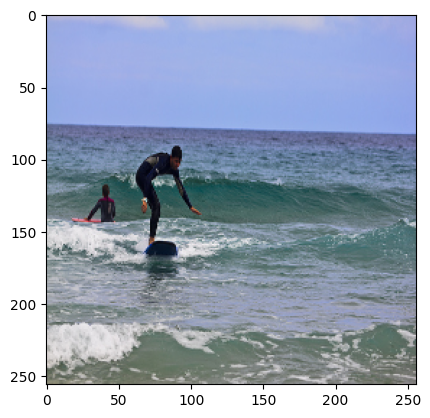

In [13]:
show_example(encoder, decoder, val_dataloader)

Validation: 100%|██████████| 97/97 [00:31<00:00,  3.09it/s, Val Loss=0.3954]


Epoch 1/20, Avg Train Loss: 0.3937, Avg Val Loss: 0.3954

Generated Caption:  a surfer in a blacksuit is to catch on a waveboard.

Original Caption:  a man in a wetsuit trying to balance on a surfboard.


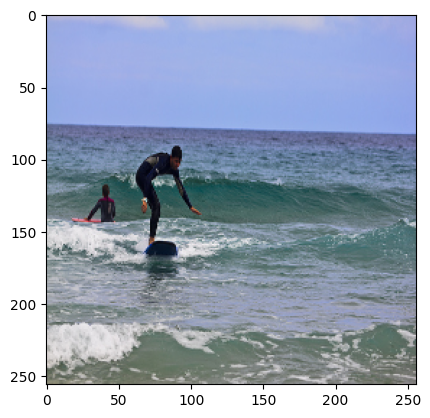

Validation:  80%|████████  | 78/97 [00:24<00:06,  3.17it/s, Val Loss=0.3902]

In [ ]:
# Early stopping parameters
patience = 10
best_val_loss = float('inf')
patience_counter = 0
num_epochs = 20

train_losses = []
val_losses = []

cnt = 0
for epoch in range(num_epochs):
    cnt = cnt+1;
    encoder.train()
    decoder.train()
    train_loss = 0.0
    
    # Initialize tqdm for the training loop
    train_bar = tqdm(train_dataloader, total=len(train_dataloader), desc=f"Epoch {epoch+1}/{num_epochs}")
    
    for sample in train_bar:
        image, captions = sample['image'].to(device), sample['captions'].to(device).squeeze(1)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        features = encoder(image)
        outputs = decoder(features, captions)
        
        # Compute the loss
        loss = criterion(outputs.view(-1, vocab_size), captions.view(-1))
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        
        # Update tqdm bar
        train_bar.set_postfix({'Train Loss': f"{train_loss/(train_bar.n+1):.4f}"})
    
    # Calculate average training loss for the epoch
    avg_train_loss = train_loss / len(train_dataloader)
    train_losses.append(avg_train_loss)
    
    # Validation loop
    encoder.eval()
    decoder.eval()
    val_loss = 0.0
    
    with torch.no_grad():
        val_bar = tqdm(val_dataloader, total=len(val_dataloader), desc="Validation")
        for sample in val_bar:
            image, captions = sample['image'].to(device), sample['captions'].to(device).squeeze(1)
            
            features = encoder(image)
            outputs = decoder(features, captions)
            
            loss = criterion(outputs.view(-1, vocab_size), captions.view(-1))
            val_loss += loss.item()
            
            # Update tqdm bar
            val_bar.set_postfix({'Val Loss': f"{val_loss/(val_bar.n+1):.4f}"})
    
    # Calculate average validation loss
    avg_val_loss = val_loss / len(val_dataloader)
    val_losses.append(avg_val_loss)
    
    print(f"Epoch {epoch+1}/{num_epochs}, Avg Train Loss: {avg_train_loss:.4f}, Avg Val Loss: {avg_val_loss:.4f}")
    
    show_example(encoder, decoder, val_dataloader)
    
    if(cnt%3==0):
        torch.save({
            'encoder_state_dict': encoder.state_dict(),
            'decoder_state_dict': decoder.state_dict(),
        }, f'/kaggle/working/image-to-text{cnt}.pth')
    
#     # Early stopping check
#     if avg_val_loss < best_val_loss:
#         best_val_loss = avg_val_loss
#         patience_counter = 0
#     else:
#         patience_counter += 1
    
#     if patience_counter >= patience:
#         print(f"Early stopping triggered after {epoch+1} epochs")
#         break


        
path='/kaggle/working/image-to-text.pth'
torch.save({
    'encoder_state_dict': encoder.state_dict(),
    'decoder_state_dict': decoder.state_dict(),
}, path)

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [39]:
def generate_caption(image_path, encoder, decoder, tokenizer):
    # Set models to evaluation mode
    encoder.eval()
    decoder.eval()

    # Load the image
    image = Image.open(image_path).convert("RGB")

    # Apply transformations to the image
    transform = T.Compose([
        T.ToTensor(),
        T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
        T.Resize((256, 256)),
    ])

    # Preprocess the image
    image = transform(image).unsqueeze(0).to(device)  # Add batch dimension

    # Pass the image through the encoder
    with torch.no_grad():
        features = encoder(image).unsqueeze(1)
        output = decoder.sample(features)   # token_ids

    # Decode token IDs to string and remove anything after [SEP] token
    sentence = tokenizer.decode(output, skip_special_tokens=True)

    # Display the image with the generated caption
    plt.imshow(Image.open(image_path))
    plt.axis('off')
    plt.title('Generated Caption: ' + sentence)
    plt.show()

    return sentence

original_caption = A little girl in a pink shirt and a little girl in an orange shirt sitting in the grass .


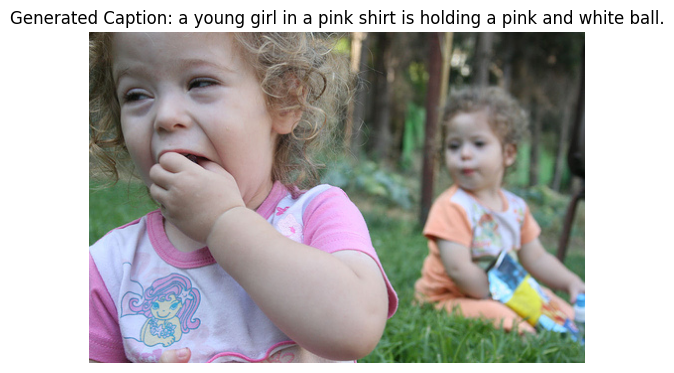

In [21]:
image_path = df["image"][210] 
original_caption = df['caption'][210]

print(f"original_caption = {original_caption}")
generated_caption = generate_caption(image_path, encoder, decoder, tokenizer)

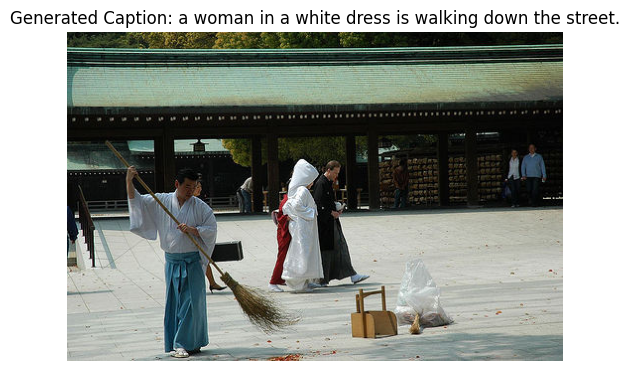

In [24]:
image_path = df["image"][202]
caption = generate_caption(image_path, encoder, decoder, tokenizer)

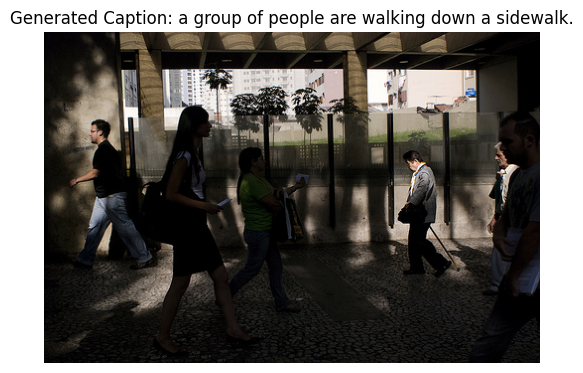

Original Caption: A crowd of students pass each other in a dark hall  as they walk to class .
BLEU Score = 0.5856596027429395




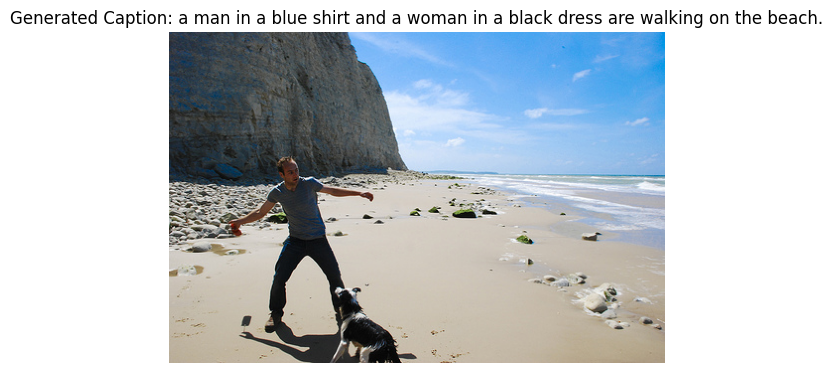

Original Caption: A man playing with his dog on a beach
BLEU Score = 0.27952792741962756




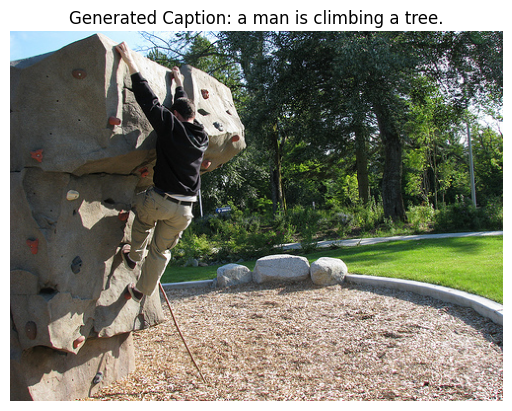

Original Caption: adult man climbing a rock in a park .
BLEU Score = 0.48549177170732344




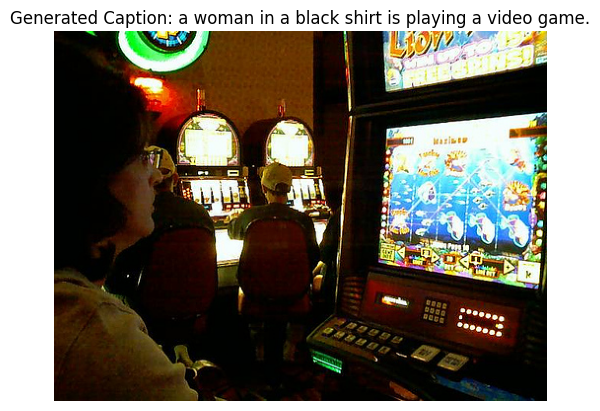

Original Caption: A woman sits down to play a casino video game .
BLEU Score = 0.7226568811456053




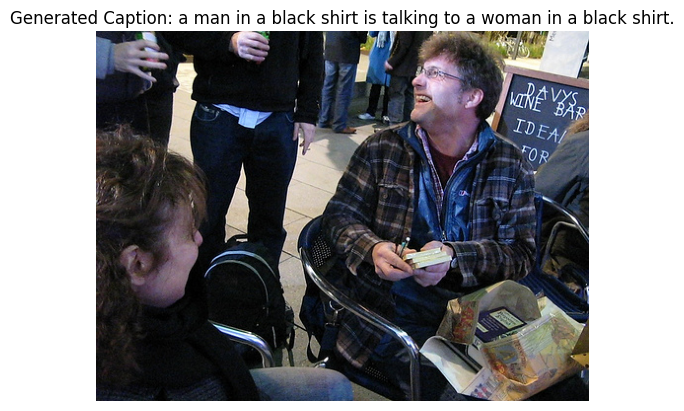

Original Caption: A man holding some small books talks to several other people .
BLEU Score = 0.49760938992507125




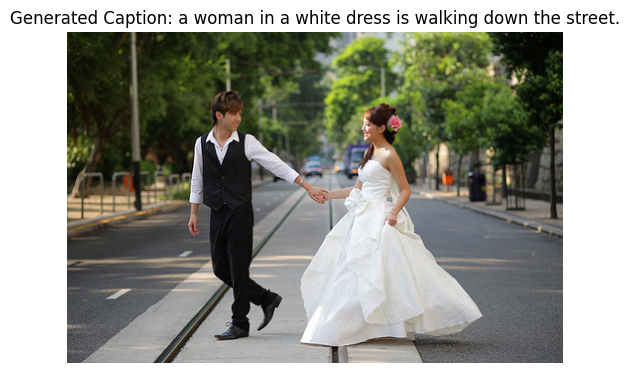

Original Caption: A man in a suit and a woman in a wedding dress walking across the street .
BLEU Score = 0.16467029855845897




In [40]:
cnt = 0
for _, sample in val.sample(n=100).iterrows():
    image, original_caption = sample
            
    generated_caption = generate_caption(image, encoder, decoder, tokenizer)
    
    print(f"Original Caption: {original_caption}")
        
    score = sentence_bleu([generated_caption.split()], original_caption.split())

    print(f"BLEU Score = {score}\n\n")
    
    cnt = cnt + 1
    if (cnt > 5):
        break

In [36]:
total_score = 0
for _, sample in tqdm(val.iterrows(), total=len(val)):
    image, original_caption = sample
            
    generated_caption = generate_caption(image, encoder, decoder, tokenizer)
            
    score = sentence_bleu([generated_caption.split()], original_caption.split())
            
    total_score += score

100%|██████████| 3115/3115 [01:14<00:00, 42.08it/s]


In [38]:
print(f"Average BLEU Score: {total_score / len(val):.4f}")

Average BLEU Score: 0.4112


In [37]:
print(len(good_image))

173


In [57]:
# sample = next(iter(val_dataloader))

# image_transformed = sample['image'][0][0]
# caption_encoded = sample['captions'][0][0]

# original_caption = tokenizer.decode(caption_encoded, skip_special_tokens=True)
# original_caption
# # sample['captions']

'a group of tourists looking at a set of columnar ruins.'